In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  
from IPython.display import HTML

In [2]:
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, precision_score, recall_score
import pandas
import numpy as np
import json
import matplotlib.pyplot as plt
import os

pandas.options.display.float_format = '{:,.3f}'.format

In [3]:
from evaluate import load, get_results, get_labels, transform_binary_probabilities, transform_binary_predictions, calculate_accuracy_loss, plot_confusion_matrix, plot_precision_recall, plot_roc_curve, calculate_pr_auc, calculate_confusion_matrix_stats, calculate_confusion_matrix, plot_tsne, accession_from_filename, plot_expert_confusion, plot_grad_cam

Using TensorFlow backend.


In [4]:
from data import describe, all_features, data, print_describe
from run import characterize_data

# All lesions

In [5]:
DIRECTORY = "complete-set-free/data"
FEATURES = "{}/features.csv".format(DIRECTORY)
RAW = "{}/raw".format(DIRECTORY)
TRAIN = "{}/train".format(DIRECTORY)
VALIDATION = "{}/validation".format(DIRECTORY)
MODEL = "/data/intrepidlemon/deep-ultrasound/output2/models/6c9f058d-62c7-4e14-a6bd-1d5cd797b700-v1.h5"

## Lesion descriptions

In [6]:
print_describe(raw=RAW, features=FEATURES)

category: C2
	count: 157
	number lesions: 158
	column: feat
		 {'benign': 157}
	column: imag
		 {'biopsy': 1, 'mri': 156}
category: C3
	count: 131
	number lesions: 198
	column: feat
		 {'benign': 113, 'malignant': 18}
	column: imag
		 {'biopsy': 6, 'mri': 125}
category: C4
	count: 44
	number lesions: 59
	column: feat
		 {'benign': 10, 'malignant': 34}
	column: imag
		 {'biopsy': 16, 'mri': 28}
category: C5
	count: 78
	number lesions: 106
	column: feat
		 {'benign': 2, 'malignant': 76}
	column: imag
		 {'biopsy': 33, 'mri': 45}


In [7]:
train, validation, _ = data(shuffle_train=False, validation_dir=VALIDATION, train_dir=TRAIN)

Found 593 images belonging to 2 classes.
Found 593 images belonging to 2 classes.
Found 335 images belonging to 2 classes.
Found 0 images belonging to 2 classes.


In [8]:
print("training data breakdown: ", characterize_data(train))
print("validation data breakdown: ", characterize_data(validation))

training data breakdown:  {'benign': 380, 'malignant': 213}
validation data breakdown:  {'benign': 211, 'malignant': 124}


In [9]:
model = load(MODEL)

In [10]:
results = get_results(model, validation)

In [11]:
probabilities = transform_binary_probabilities(results)
predictions = transform_binary_predictions(results)
labels = get_labels(validation)

## Accuracy and loss

In [12]:
loss, accuracy = calculate_accuracy_loss(model, validation)
print("Accuracy:", accuracy)
print("Loss:", loss)

Accuracy: 0.7641791055451578
Loss: 0.5609222152339879


## Confusion matrix

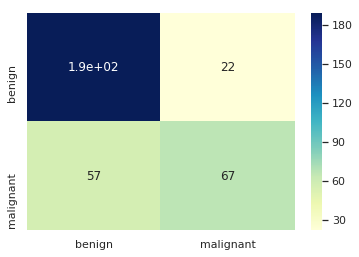

In [13]:
plot_confusion_matrix(validation, results)

In [14]:
stats = calculate_confusion_matrix_stats(validation, results)
pandas.DataFrame(stats, index=validation.class_indices)

,Acc,TP,TN,FP,FN,TPR,TNR,PPV,NPV,FPR,FNR,FDR,AM,GM
benign,0.764,189,67,57,22,0.896,0.540,0.768,0.753,0.460,0.104,0.232,0.718,0.696
malignant,0.764,67,189,22,57,0.540,0.896,0.753,0.768,0.104,0.460,0.247,0.718,0.696


## ROC Curve standalone

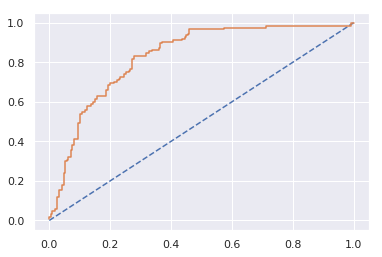

In [15]:
plot_roc_curve(validation, results)

In [16]:
print("ROC AUC:", roc_auc_score(labels, probabilities))

ROC AUC: 0.8296514294450391


## Precision Recall

In [17]:
print("Average precision:", average_precision_score(labels, probabilities))
print("Precision:", precision_score(labels, predictions), "Recall:", recall_score(labels, predictions))

Average precision: 0.6868847204662996
Precision: 0.7528089887640449 Recall: 0.5403225806451613


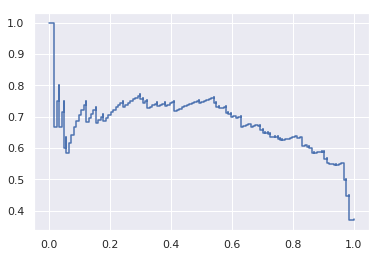

In [18]:
plot_precision_recall(validation, results)

In [19]:
print("PR AUC:", calculate_pr_auc(validation, results))

PR AUC: 0.6834411315046924


## F1 Score

In [20]:
print("F1 score:", f1_score(labels, predictions))

F1 score: 0.6291079812206571


## TSNE

In [21]:
malignancy, modality, category = all_features(features=FEATURES)

In [22]:
tsne_dataset = train

In [23]:
tsne_labels = [category.get(accession_from_filename(f), "unknown") for f in tsne_dataset.filenames]

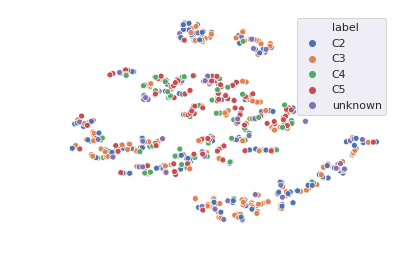

In [24]:
plot_tsne(model, "dense_5", tsne_dataset, tsne_labels, perplexity=5)

## Experts

error with benign/free-27244981-liver.jpeg: '27244981-liver.jpeg'
error with benign/free-27741572-liver.jpeg: '27741572-liver.jpeg'
error with malignant/free-30095075-liver.jpeg: '30095075-liver.jpeg'


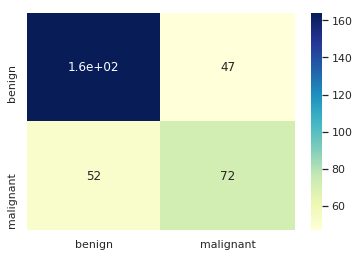

In [25]:
expert_1 = plot_expert_confusion("evaluations/radiology-9809.json", validation)

In [26]:
pandas.DataFrame(expert_1, index=validation.class_indices)

,Acc,TP,TN,FP,FN,TPR,TNR,PPV,NPV,FPR,FNR,FDR,AM,GM
benign,0.704,164,72,52,47,0.777,0.581,0.759,0.605,0.419,0.223,0.241,0.679,0.672
malignant,0.704,72,164,47,52,0.581,0.777,0.605,0.759,0.223,0.419,0.395,0.679,0.672


## ROC with experts

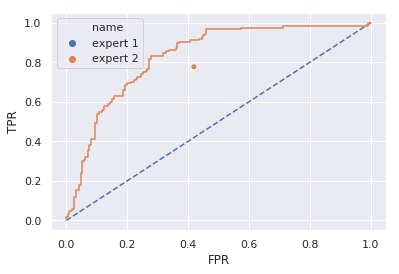

In [27]:
plot_roc_curve(validation, results, experts=[{ **expert_1, "name":"expert 1" }, { **expert_1, "name":"expert 2" }])

## Grad Cam

### benign example

/home/harrison/.local/share/virtualenvs/deep-ultrasound-k5cplrX3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/harrison/.local/share/virtualenvs/deep-ultrasound-k5cplrX3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


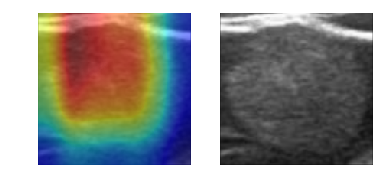

In [28]:
plot_grad_cam(
    os.path.join(validation.directory, validation.filenames[0]), 
    model, 
    "dense_6", 
)

### malignant example

/home/harrison/.local/share/virtualenvs/deep-ultrasound-k5cplrX3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/harrison/.local/share/virtualenvs/deep-ultrasound-k5cplrX3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


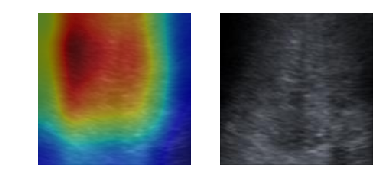

In [29]:
plot_grad_cam(
    os.path.join(validation.directory, validation.filenames[len(validation.filenames) - 1]), 
    model, 
    "dense_6", 
)

In [30]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')